<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 5185, '日付': '2022-01-18T08:00:00.000Z'},
 {'小計': 7377, '日付': '2022-01-19T08:00:00.000Z'},
 {'小計': 8638, '日付': '2022-01-20T08:00:00.000Z'},
 {'小計': 9699, '日付': '2022-01-21T08:00:00.000Z'},
 {'小計': 11227, '日付': '2022-01-22T08:00:00.000Z'},
 {'小計': 9468, '日付': '2022-01-23T08:00:00.000Z'},
 {'小計': 8503, '日付': '2022-01-24T08:00:00.000Z'},
 {'小計': 12813, '日付': '2022-01-25T08:00:00.000Z'},
 {'小計': 14086, '日付': '2022-01-26T08:00:00.000Z'},
 {'小計': 16538, '日付': '2022-01-27T08:00:00.000Z'},
 {'小計': 17631, '日付': '2022-01-28T08:00:00.000Z'},
 {'小計': 17433, '日付': '2022-01-29T08:00:00.000Z'},
 {'小計': 15895, '日付': '2022-01-30T08:00:00.000Z'},
 {'小計': 11751, '日付': '2022-01-31T08:00:00.000Z'},
 {'小計': 14445, '日付': '2022-02-01T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-01-28 17:00:00+09:00,2586,0,17631,2022-01-28 17:00:00+09:00
2022-01-29 17:00:00+09:00,3209,0,17433,2022-01-29 17:00:00+09:00
2022-01-30 17:00:00+09:00,2452,0,15895,2022-01-30 17:00:00+09:00
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-01-28 17:00:00+09:00,2586,0,17631,2022-01-28 17:00:00+09:00,2600.714286,18205.0,0.0,0.0,12895.142857,90266.0
2022-01-29 17:00:00+09:00,3209,0,17433,2022-01-29 17:00:00+09:00,2673.428571,18714.0,0.0,0.0,13781.714286,96472.0
2022-01-30 17:00:00+09:00,2452,0,15895,2022-01-30 17:00:00+09:00,2674.285714,18720.0,0.0,0.0,14699.857143,102899.0
2022-01-31 17:00:00+09:00,3277,0,11751,2022-01-31 17:00:00+09:00,2723.000000,19061.0,0.0,0.0,15163.857143,106147.0
2022-02-01 17:00:00+09:00,0,0,14445,2022-02-01 17:00:00+09:00,2351.571429,16461.0,0.0,0.0,15397.000000,107779.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-01-18 17:00:00+09:00,1915,0,5185,2022-01-18 17:00:00+09:00,1586.428571,11105.0,0.0,0.0,3859.142857,27014.0,'22w03,Tue
2022-01-19 17:00:00+09:00,2218,0,7377,2022-01-19 17:00:00+09:00,1765.571429,12359.0,0.0,0.0,4599.000000,32193.0,'22w03,Wed
2022-01-20 17:00:00+09:00,2014,0,8638,2022-01-20 17:00:00+09:00,1892.571429,13248.0,0.0,0.0,5386.714286,37707.0,'22w03,Thu
2022-01-21 17:00:00+09:00,1994,0,9699,2022-01-21 17:00:00+09:00,1980.000000,13860.0,0.0,0.0,6193.000000,43351.0,'22w03,Fri
2022-01-22 17:00:00+09:00,2700,0,11227,2022-01-22 17:00:00+09:00,2091.857143,14643.0,0.0,0.0,7145.285714,50017.0,'22w03,Sat
2022-01-23 17:00:00+09:00,2446,0,9468,2022-01-23 17:00:00+09:00,2190.857143,15336.0,0.0,0.0,7901.857143,55313.0,'22w03,Sun
2022-01-24 17:00:00+09:00,2936,0,8503,2022-01-24 17:00:00+09:00,2317.571429,16223.0,0.0,0.0,8585.285714,60097.0,'22w04,Mon
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00,2415.428571,16908.0,0.0,0.0,9675.000000,67725.0,'22w04,Tue
2022-01-26 17:00:00+09:00,2517,0,14086,2022-01-26 17:00:00+09:00,2458.142857,17207.0,0.0,0.0,10633.428571,74434.0,'22w04,Wed
2022-01-27 17:00:00+09:00,2420,0,16538,2022-01-27 17:00:00+09:00,2516.142857,17613.0,0.0,0.0,11762.000000,82334.0,'22w04,Thu


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-01-16 17:00:00+09:00,2849.000000,19943
2022-01-23 17:00:00+09:00,7901.857143,55313
2022-01-30 17:00:00+09:00,14699.857143,102899
2022-02-01 17:00:00+09:00,13098.000000,26196
2022-01-02 17:00:00+09:00,81.500000,163


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-01-18 17:00:00+09:00,1915,0,5185,2022-01-18 17:00:00+09:00,1586.428571,11105.0,0.0,0.0,3859.142857,27014.0,'22w03,Tue,NaN,NaN
2022-01-19 17:00:00+09:00,2218,0,7377,2022-01-19 17:00:00+09:00,1765.571429,12359.0,0.0,0.0,4599.000000,32193.0,'22w03,Wed,NaN,NaN
2022-01-20 17:00:00+09:00,2014,0,8638,2022-01-20 17:00:00+09:00,1892.571429,13248.0,0.0,0.0,5386.714286,37707.0,'22w03,Thu,NaN,NaN
2022-01-21 17:00:00+09:00,1994,0,9699,2022-01-21 17:00:00+09:00,1980.000000,13860.0,0.0,0.0,6193.000000,43351.0,'22w03,Fri,NaN,NaN
2022-01-22 17:00:00+09:00,2700,0,11227,2022-01-22 17:00:00+09:00,2091.857143,14643.0,0.0,0.0,7145.285714,50017.0,'22w03,Sat,NaN,NaN
2022-01-23 17:00:00+09:00,2446,0,9468,2022-01-23 17:00:00+09:00,2190.857143,15336.0,0.0,0.0,7901.857143,55313.0,'22w03,Sun,7901.857143,55313.0
2022-01-24 17:00:00+09:00,2936,0,8503,2022-01-24 17:00:00+09:00,2317.571429,16223.0,0.0,0.0,8585.285714,60097.0,'22w04,Mon,NaN,NaN
2022-01-25 17:00:00+09:00,2600,0,12813,2022-01-25 17:00:00+09:00,2415.428571,16908.0,0.0,0.0,9675.000000,67725.0,'22w04,Tue,NaN,NaN
2022-01-26 17:00:00+09:00,2517,0,14086,2022-01-26 17:00:00+09:00,2458.142857,17207.0,0.0,0.0,10633.428571,74434.0,'22w04,Wed,NaN,NaN
2022-01-27 17:00:00+09:00,2420,0,16538,2022-01-27 17:00:00+09:00,2516.142857,17613.0,0.0,0.0,11762.000000,82334.0,'22w04,Thu,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

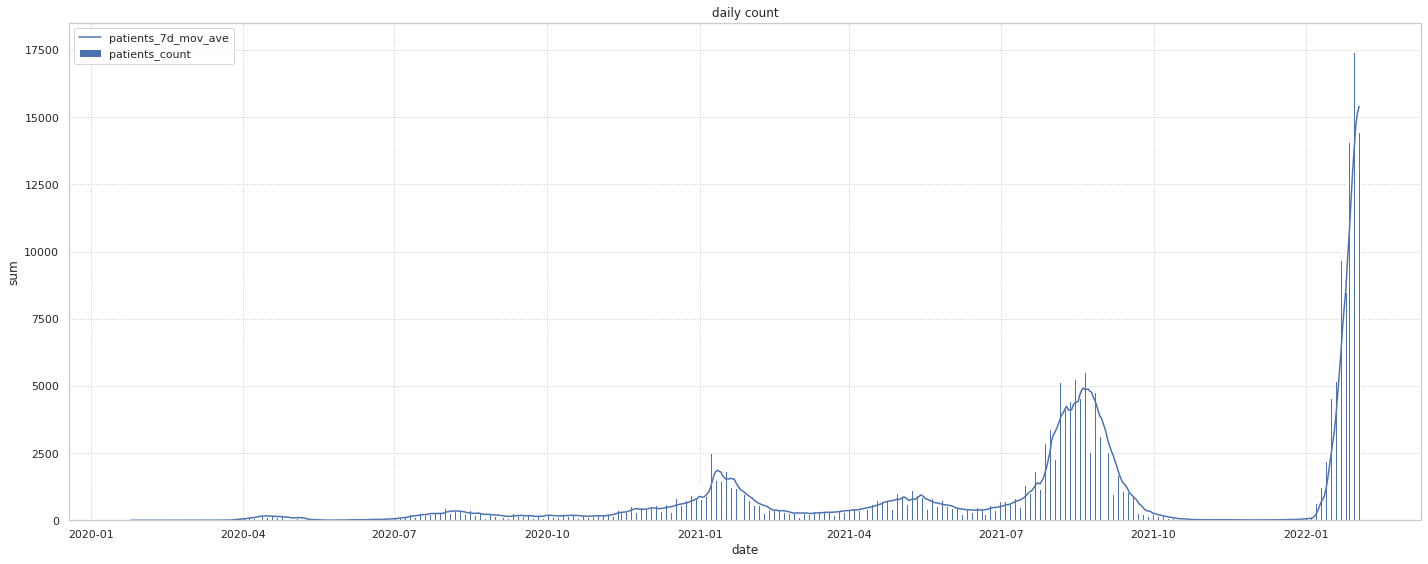

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
725,1.642493e+09,2022,1,18,0,0,0,0,0,1,0,725,0,651,1915,1586.428571,11105.0,0,0.0,0.0,5185,3859.142857,27014.0
726,1.642579e+09,2022,1,19,0,0,0,0,0,0,1,726,0,652,2218,1765.571429,12359.0,0,0.0,0.0,7377,4599.000000,32193.0
727,1.642666e+09,2022,1,20,0,0,0,0,1,0,0,727,0,653,2014,1892.571429,13248.0,0,0.0,0.0,8638,5386.714286,37707.0
728,1.642752e+09,2022,1,21,1,0,0,0,0,0,0,728,0,654,1994,1980.000000,13860.0,0,0.0,0.0,9699,6193.000000,43351.0
729,1.642838e+09,2022,1,22,0,0,1,0,0,0,0,729,0,655,2700,2091.857143,14643.0,0,0.0,0.0,11227,7145.285714,50017.0
730,1.642925e+09,2022,1,23,0,0,0,1,0,0,0,730,0,656,2446,2190.857143,15336.0,0,0.0,0.0,9468,7901.857143,55313.0
731,1.643011e+09,2022,1,24,0,1,0,0,0,0,0,731,0,657,2936,2317.571429,16223.0,0,0.0,0.0,8503,8585.285714,60097.0
732,1.643098e+09,2022,1,25,0,0,0,0,0,1,0,732,0,658,2600,2415.428571,16908.0,0,0.0,0.0,12813,9675.000000,67725.0
733,1.643184e+09,2022,1,26,0,0,0,0,0,0,1,733,0,659,2517,2458.142857,17207.0,0,0.0,0.0,14086,10633.428571,74434.0
734,1.643270e+09,2022,1,27,0,0,0,0,1,0,0,734,0,660,2420,2516.142857,17613.0,0,0.0,0.0,16538,11762.000000,82334.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            740 non-null    float64
 1   year                 740 non-null    int64  
 2   month                740 non-null    int64  
 3   day                  740 non-null    int64  
 4   Fri                  740 non-null    uint8  
 5   Mon                  740 non-null    uint8  
 6   Sat                  740 non-null    uint8  
 7   Sun                  740 non-null    uint8  
 8   Thu                  740 non-null    uint8  
 9   Tue                  740 non-null    uint8  
 10  Wed                  740 non-null    uint8  
 11  passed               740 non-null    int64  
 12  emergency            740 non-null    int64  
 13  em_passed            740 non-null    int64  
 14  contacts_count       740 non-null    int64  
 15  contacts_7d_mov_ave  740 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.400000e+02,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,1.611778e+09,2020.579730,6.454054,15.845946,0.143243,0.143243,0.143243,0.143243,0.141892,0.143243,0.141892,369.500000,0.066216,299.250000,656.689189,648.309234,4538.159459,497.998649,497.998649,3485.990541,800.308108,739.866467,5179.043243
std,1.846920e+07,0.574958,3.481915,8.860400,0.350558,0.350558,0.350558,0.350558,0.349175,0.350558,0.349175,213.763888,0.248828,208.026843,544.401217,517.854725,3624.989535,794.144861,728.327674,5098.293716,1965.411592,1691.168628,11838.190039
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.595815e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,184.750000,0.000000,110.750000,314.750000,320.321429,2242.250000,0.000000,0.000000,0.000000,45.750000,44.000000,308.000000
50%,1.611778e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,369.500000,0.000000,295.500000,503.500000,492.357143,3446.500000,0.000000,0.000000,0.000000,242.500000,257.071429,1799.500000
75%,1.627740e+09,2021.000000,9.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,554.250000,0.000000,480.250000,788.000000,768.928571,5382.500000,1003.500000,1054.535714,7381.750000,602.000000,603.928571,4227.500000
max,1.643702e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,739.000000,1.000000,665.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,17631.000000,15397.000000,107779.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.874339,0.282454,0.018866,-0.003828,0.001914,-0.001914,7.785887e-19,0.000952,0.003828,-0.000952,1.000000e+00,-0.338445,0.998431,-0.126488,-0.143346,-0.143343,-0.617775,-0.663993,-0.663993,0.374328,0.379379,0.379382
year,8.743386e-01,1.000000,-0.216831,-0.017507,-0.003030,0.003683,0.003683,3.683447e-03,-0.005875,0.003683,-0.005875,8.743386e-01,-0.268684,0.880251,-0.015912,-0.037784,-0.037782,-0.633148,-0.690364,-0.690364,0.476298,0.469414,0.469416
month,2.824541e-01,-0.216831,1.000000,-0.010713,-0.002361,-0.003470,-0.011230,-7.904074e-03,0.013717,0.000965,0.010378,2.824541e-01,-0.148764,0.267452,-0.228352,-0.218047,-0.218045,0.009412,0.030534,0.030534,-0.198221,-0.173826,-0.173823
day,1.886560e-02,-0.017507,-0.010713,1.000000,0.007985,0.000579,0.000579,7.114129e-03,-0.001673,-0.006827,-0.007796,1.886560e-02,-0.004573,0.019807,0.063242,0.051187,0.051185,-0.000910,-0.012334,-0.012334,0.105070,0.098287,0.098285
Fri,-3.828226e-03,-0.003030,-0.002361,0.007985,1.000000,-0.167192,-0.167192,-1.671924e-01,-0.166271,-0.167192,-0.166271,-3.828226e-03,-0.000293,-0.003349,-0.016004,-0.004295,-0.004294,0.025830,-0.000754,-0.000754,0.017632,-0.005305,-0.005307
Mon,1.914113e-03,0.003683,-0.003470,0.000579,-0.167192,1.000000,-0.167192,-1.671924e-01,-0.166271,-0.167192,-0.166271,1.914113e-03,-0.000293,0.001939,0.040267,0.005223,0.005223,0.104175,-0.000754,-0.000754,-0.050800,0.009392,0.009392
Sat,-1.914113e-03,0.003683,-0.011230,0.000579,-0.167192,-0.167192,1.000000,-1.671924e-01,-0.166271,-0.167192,-0.166271,-1.914113e-03,-0.000293,-0.001587,0.044960,-0.000878,-0.000877,-0.121740,-0.000754,-0.000754,0.022166,0.000379,0.000378
Sun,7.785887e-19,0.003683,-0.007904,0.007114,-0.167192,-0.167192,-0.167192,1.000000e+00,-0.166271,-0.167192,-0.166271,2.566149e-19,-0.000293,0.000176,-0.018599,0.001733,0.001734,-0.112218,-0.000754,-0.000754,-0.008680,0.005561,0.005561
Thu,9.517811e-04,-0.005875,0.013717,-0.001673,-0.166271,-0.166271,-0.166271,-1.662708e-01,1.000000,-0.166271,-0.165354,9.517811e-04,0.000737,0.000442,-0.009164,-0.002225,-0.002224,0.032452,0.001893,0.001893,0.022273,-0.009405,-0.009404
Tue,3.828226e-03,0.003683,0.000965,-0.006827,-0.167192,-0.167192,-0.167192,-1.671924e-01,-0.166271,1.000000,-0.166271,3.828226e-03,-0.000293,0.003702,-0.027753,0.005223,0.005223,0.041146,-0.000754,-0.000754,-0.001814,0.014102,0.014102


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,1.643357e+09,1,0,0,0,0,0,0,735,0,661,2586,0,17631,12895.142857,90266.0
736,1.643443e+09,0,0,1,0,0,0,0,736,0,662,3209,0,17433,13781.714286,96472.0
737,1.643530e+09,0,0,0,1,0,0,0,737,0,663,2452,0,15895,14699.857143,102899.0
738,1.643616e+09,0,1,0,0,0,0,0,738,0,664,3277,0,11751,15163.857143,106147.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
735,1.643357e+09,735,0,17631,12895.142857,90266.0
736,1.643443e+09,736,0,17433,13781.714286,96472.0
737,1.643530e+09,737,0,15895,14699.857143,102899.0
738,1.643616e+09,738,0,11751,15163.857143,106147.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

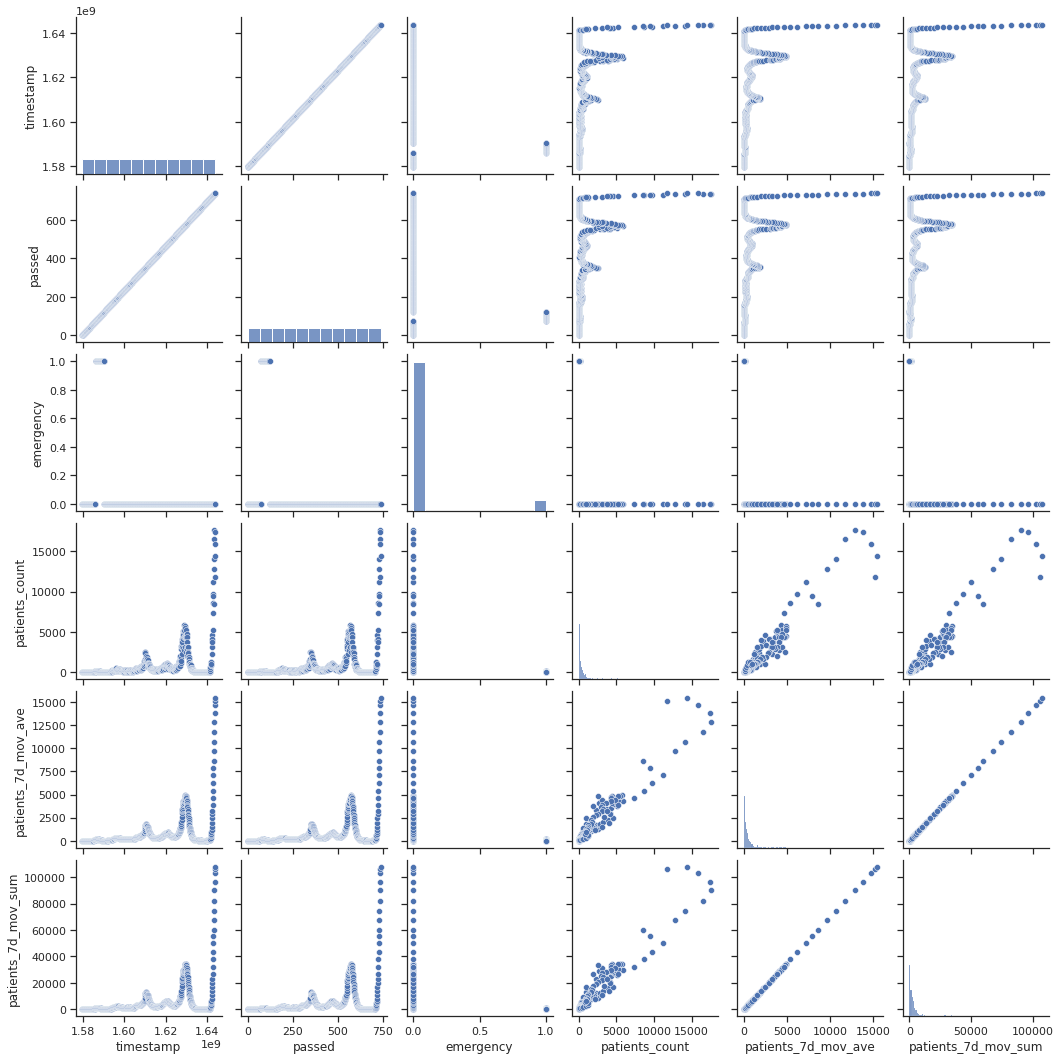

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.10
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.26
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==